In [ ]:
import keras
import keras.layers as layers
from keras.models import Model
from keras.optimizers import *
import matplotlib.pyplot as plt
from keras import backend as K
from keras.metrics import MeanIoU
import numpy as np
from PIL import Image
from sklearn.metrics import f1_score
from google.colab.patches import cv2_imshow
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, DepthwiseConv2D, Activation, UpSampling2D, Lambda, multiply, Dropout, add, Input, Concatenate,MaxPooling2D, BatchNormalization, concatenate,Conv2DTranspose

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install segmentation-models==1.0.1
%env SM_FRAMEWORK=tf.keras
import segmentation_models as sm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 8.4 MB/s eta 0:00:00
env: SM_FRAMEWORK=tf.keras
Segmentation Models: using `tf.keras` framework.


In [ ]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)
tf.config.run_functions_eagerly(True)

/usr/local/lib/python3.10/dist-packages/tensorflow/python/client/session.py:1769: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


In [ ]:

import numpy as np

train_img_np_path = '/content/drive/MyDrive/Major_Project_Resources/fire_segmentation/Dataset_512_npy/Train_img_small.npy'
train_mask_np_path = '/content/drive/MyDrive/Major_Project_Resources/fire_segmentation/Dataset_512_npy/Train_mask_small.npy'

val_img_np_path = '/content/drive/MyDrive/Major_Project_Resources/fire_segmentation/Dataset_512_npy/Val_img.npy'
val_mask_np_path = '/content/drive/MyDrive/Major_Project_Resources/fire_segmentation/Dataset_512_npy/Val_mask.npy'

test_img_np_path = '/content/drive/MyDrive/Major_Project_Resources/fire_segmentation/Dataset_512_npy/Test_img.npy'
test_mask_np_path = '/content/drive/MyDrive/Major_Project_Resources/fire_segmentation/Dataset_512_npy/Test_mask.npy'

train_img = np.load(train_img_np_path)
train_mask = np.load(train_mask_np_path)
train_mask = np.array(train_mask)/255
val_img = np.load(val_img_np_path)
val_mask = np.load(val_mask_np_path)
val_mask = np.array(val_mask)/255
test_img = np.load(test_img_np_path)
test_mask = np.load(test_mask_np_path)
test_mask = np.array(test_mask)/255

In [ ]:
def dice_coef_loss(y_true,y_pred):
  y_true_f=K.flatten(y_true)
  y_pred_f=K.flatten(y_pred)
  intersection=K.sum(y_true_f*y_pred_f)
  return 1-(2*intersection)/(K.sum(y_true_f*y_true_f)+K.sum(y_pred_f*y_pred_f))

#def iou_score(y_pred, y_true, smooth=1):
#    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
#    union = K.sum(y_true, -1) + K.sum(y_pred, -1) - intersection
#    iou = (intersection + smooth)/(union + smooth)
#    return iou

import keras.backend as K

from keras import backend as K
def iou_coef(y_true, y_pred, smooth=1):
  intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
  union = K.sum(y_true,[1,2,3])+K.sum(y_pred,[1,2,3])-intersection
  iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
  return iou

def f1_metric(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


def dice_coef_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)


def tversky(y_true, y_pred, smooth=1, alpha=0.7):
    y_true_pos = K.flatten(y_true)
    y_pred_pos = K.flatten(y_pred)
    true_pos = K.sum(y_true_pos * y_pred_pos)
    false_neg = K.sum(y_true_pos * (1 - y_pred_pos))
    false_pos = K.sum((1 - y_true_pos) * y_pred_pos)
    return (true_pos + smooth) / (true_pos + alpha * false_neg + (1 - alpha) * false_pos + smooth)


def tversky_loss(y_true, y_pred):
    return 1 - tversky(y_true, y_pred)


def focal_tversky_loss(y_true, y_pred, gamma=0.75):
    tv = tversky(y_true, y_pred)
    return K.pow((1 - tv), gamma)

In [ ]:
def model_unet_kaggle(img_hieght, img_width, img_channel, num_classes):
    """
    This function returns a U-Net Model for this binary fire segmentation images:
    Arxiv Link for U-Net: https://arxiv.org/abs/1505.04597
    :param img_hieght: Image Height
    :param img_width: Image Width
    :param img_channel: Number of channels in each image
    :param num_classes: Number of classes based on the Ground Truth Masks
    :return: A convolutional NN based on Tensorflow and Keras
    """
    inputs = Input((img_hieght, img_width, img_channel))
    s = Lambda(lambda x: x / 255)(inputs)

    c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(s)
    c1 = Dropout(0.1)(c1)
    c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)

    c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(c5)

    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(c6)

    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(c7)

    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(c8)

    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(c9)

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)

    model = Model(inputs=[inputs], outputs=[outputs])
    return model

In [ ]:
model_base=model_unet_kaggle(512, 512, 3,1)

In [ ]:
model_base.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 lambda (Lambda)                (None, 512, 512, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 512, 512, 16  448         ['lambda[0][0]']                 
                                )                                                                 
                                                                                              

In [ ]:
mcp_save = tf.keras.callbacks.ModelCheckpoint('/content/drive/MyDrive/Major_Project_Resources/fire_segmentation/Proposed_Models/unet_kaggle_focal.h5',monitor = 'val_iou_coef', verbose=1, save_best_only=True, save_weights_only=False, mode='max')
model_base.compile(loss=focal_tversky_loss,
             optimizer='adam',
             metrics=['accuracy',iou_coef,
              tf.keras.metrics.AUC(name='auc'),
              tf.keras.metrics.Precision(name='precision'),
              tf.keras.metrics.Recall(name='recall'),
              f1_metric])

In [ ]:
model_history = model_base.fit(train_img,train_mask,validation_data=(val_img,val_mask),epochs=50,steps_per_epoch=50,validation_steps=5,callbacks = [mcp_save])

/usr/local/lib/python3.9/dist-packages/tensorflow/python/data/ops/structured_function.py:254: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Epoch 1/50
50/50 [==============================] - ETA: 0s - loss: 0.6089 - accuracy: 0.9297 - iou_coef: 0.3112 - auc: 0.7427 - precision: 0.0615 - recall: 0.4642 - f1_metric: 0.4645
Epoch 1: val_iou_coef improved from -inf to 0.54079, saving model to /content/drive/MyDrive/Major_Project_Resources/fire_segmentation/Proposed_Models/unet_kaggle_focal.h5
50/50 [==============================] - 83s 1s/step - loss: 0.6089 - accuracy: 0.9297 - iou_coef: 0.3112 - auc: 0.7427 - precision: 0.0615 - recall: 0.4642 - f1_metric: 0.4645 - val_loss: 0.3700 - val_accuracy: 0.9930 - val_iou_coef: 0.5408 - val_auc: 0.7813 - val_precision: 0.8507 - val_recall: 0.5422 - val_f1_metric: 0.7415
Epoch 2/50
50/50 [==============================] - ETA: 0s - loss: 0.3297 - accuracy: 0.9930 - iou_coef: 0.5371 - auc: 0.8115 - precision: 0.8150 - recall: 0.5998 - f1_metric: 0.7559
Epoch 2: val_iou_coef improved from 0.54079 to 0.58115, saving model to /content/drive/MyDrive/Major_Project_Resources/fire_segmenta

In [ ]:
img_path = '/content/drive/MyDrive/Major_Project_Resources/fire_segmentation/Dataset_512/Test/img/image_5.jpg'
image = Image.open(img_path)
image
image.show()

mask_path = '/content/drive/MyDrive/Major_Project_Resources/fire_segmentation/Dataset_512/Test/mask/image_5.jpg'
mask = Image.open(mask_path)
mask.show()

In [ ]:
# Prediction code :-

from keras.models import load_model
model_path = '/content/drive/MyDrive/Major_Project_Resources/fire_segmentation/Proposed_Models/Base_Model_Seg.h5'
model = load_model(model_path,custom_objects={'iou_score':sm.metrics.IOUScore(threshold = 0.5),'f1_metric':f1_metric})
print("\n\nBase Paper model")
results = model.evaluate(test_img,test_mask)

model_path = '/content/drive/MyDrive/Major_Project_Resources/fire_segmentation/Proposed_Models/AttSqueezeUNET_small.h5'
model = load_model(model_path,custom_objects={'iou_score':sm.metrics.IOUScore(threshold = 0.5),'f1_metric':f1_metric,'focal_tversky_loss': focal_tversky_loss})
print("\n\nAttSqueezeUNET_3")
results = model.evaluate(test_img,test_mask)

model_path = '/content/drive/MyDrive/Major_Project_Resources/fire_segmentation/Proposed_Models/AttSqueezeUNET_3.1.h5'
model = load_model(model_path,custom_objects={'iou_score':sm.metrics.IOUScore(threshold = 0.5),'f1_metric':f1_metric,'focal_tversky_loss': focal_tversky_loss})
print("\n\nAttSqueezeUNET")
results = model.evaluate(test_img,test_mask)

model_path = '/content/drive/MyDrive/Major_Project_Resources/fire_segmentation/Proposed_Models/AttSqueezeUNET_2.h5'
model = load_model(model_path,custom_objects={'iou_coef':iou_coef,'f1_metric':f1_metric})
print("\n\nAttSqueezeUNET_2")
results = model.evaluate(test_img,test_mask)


#cv2_imshow(op[0])
#op=np.array(op)



Base Paper model
7/7 [==============================] - 3s 433ms/step - loss: 0.0133 - iou_score: 0.6676 - accuracy: 0.9933 - auc: 0.8900 - precision: 0.9459 - recall: 0.4926 - f1_metric: 0.8070


AttSqueezeUNET_3
7/7 [==============================] - 2s 222ms/step - loss: 0.2411 - accuracy: 0.9936 - iou_score: 0.7245 - auc: 0.8224 - precision: 0.9082 - recall: 0.6145 - f1_metric: 0.8482


ValueError: ignored

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Dropout, MaxPool2D, BatchNormalization, ReLU, LeakyReLU, UpSampling2D, Activation, ZeroPadding2D, Lambda, AveragePooling2D, Reshape
from tensorflow.keras.regularizers import l2
from tensorflow.keras.activations import sigmoid
from tensorflow.keras import Model, Sequential
def AttentionBlock(filters, g, x):
    w_g = Conv2D(filters, kernel_size=(1, 1), strides=(1, 1), use_bias=False, data_format='channels_last', kernel_initializer='he_normal')(g)
    g1 = BatchNormalization()(w_g)

    w_x = Conv2D(filters, kernel_size=(1, 1), strides=(1, 1), use_bias=False, data_format='channels_last', kernel_initializer='he_normal')(x)
    x1 = BatchNormalization()(w_x)
    relu = ReLU()(x1+g1)

    psi = Conv2D(1, kernel_size=(1, 1), strides=(1, 1), use_bias=False, data_format='channels_last', kernel_initializer='he_normal')(relu)
    psi = BatchNormalization()(psi)
    psi = Activation(activation='sigmoid')(psi)

    out = x*psi
    return out
def model_unet_kaggle(img_hieght, img_width, img_channel, num_classes):
    """
    This function returns a U-Net Model for this binary fire segmentation images:
    Arxiv Link for U-Net: https://arxiv.org/abs/1505.04597
    :param img_hieght: Image Height
    :param img_width: Image Width
    :param img_channel: Number of channels in each image
    :param num_classes: Number of classes based on the Ground Truth Masks
    :return: A convolutional NN based on Tensorflow and Keras
    """
    inputs = Input((img_hieght, img_width, img_channel))
    s = Lambda(lambda x: x / 255)(inputs)

    c1 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(s)
    c1 = Dropout(0.1)(c1)
    c1 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    c4 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)

    c5 = Conv2D(512, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(512, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(c5)

    u6 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c5)
    c4 = AttentionBlock(256, u6, c4)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(c6)

    u7 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c6)
    c3 = AttentionBlock(128, u7, c3)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(c7)

    u8 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c7)
    c2 = AttentionBlock(64, u8, c2)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(c8)

    u9 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c8)
    c1 = AttentionBlock(32, u9, c1)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(c9)

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)

    model = Model(inputs=[inputs], outputs=[outputs])
    return model

In [ ]:
model_base=model_unet_kaggle(512, 512, 3,1)

In [ ]:
model_base.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 lambda (Lambda)                (None, 512, 512, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 512, 512, 32  896         ['lambda[0][0]']                 
                                )                                                                 
                                                                                              

In [ ]:
mcp_save = tf.keras.callbacks.ModelCheckpoint('/content/drive/MyDrive/Major_Project_Resources/fire_segmentation/Proposed_Models/Attunet_kaggle_focal_large.h5',monitor = 'val_iou_coef', verbose=1, save_best_only=True, save_weights_only=False, mode='max')
model_base.compile(loss=focal_tversky_loss,
             optimizer='adam',
             metrics=['accuracy',iou_coef,
              tf.keras.metrics.AUC(name='auc'),
              tf.keras.metrics.Precision(name='precision'),
              tf.keras.metrics.Recall(name='recall'),
              f1_metric])

In [ ]:
model_history = model_base.fit(train_img,train_mask,validation_data=(val_img,val_mask),epochs=50,steps_per_epoch=100,validation_steps=5,callbacks = [mcp_save])

Epoch 1/50
100/100 [==============================] - ETA: 0s - loss: 0.4902 - accuracy: 0.9685 - iou_coef: 0.4203 - auc: 0.7607 - precision: 0.1454 - recall: 0.4758 - f1_metric: 0.6165
Epoch 1: val_iou_coef improved from -inf to 0.38956, saving model to /content/drive/MyDrive/Major_Project_Resources/fire_segmentation/Proposed_Models/Attunet_kaggle_focal_large.h5
100/100 [==============================] - 132s 1s/step - loss: 0.4902 - accuracy: 0.9685 - iou_coef: 0.4203 - auc: 0.7607 - precision: 0.1454 - recall: 0.4758 - f1_metric: 0.6165 - val_loss: 0.4575 - val_accuracy: 0.9892 - val_iou_coef: 0.3896 - val_auc: 0.8151 - val_precision: 0.5290 - val_recall: 0.6007 - val_f1_metric: 0.5788
Epoch 2/50
100/100 [==============================] - ETA: 0s - loss: 0.3052 - accuracy: 0.9933 - iou_coef: 0.5860 - auc: 0.8112 - precision: 0.8487 - recall: 0.5939 - f1_metric: 0.7852
Epoch 2: val_iou_coef improved from 0.38956 to 0.63234, saving model to /content/drive/MyDrive/Major_Project_Resourc

In [ ]:
#1
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Dropout, MaxPool2D, BatchNormalization, ReLU, LeakyReLU, UpSampling2D, Activation, ZeroPadding2D, Lambda, AveragePooling2D, Reshape
from tensorflow.keras.regularizers import l2
from tensorflow.keras.activations import sigmoid
from tensorflow.keras import Model, Sequential


def AttSqueezeUNet(image_h=512,image_w=512):
    inputs = Input(shape=(image_h, image_w, 3))
    x0 = Conv2D(64, (3, 3), strides=(2, 2), padding='same', activation='relu', kernel_initializer='he_normal')(inputs)
    x1 = MaxPool2D(pool_size=(3, 3), strides=(2, 2), padding='same')(x0)

    x2 = FireModule(2, 16, 64, x1)
    x2 = FireModule(3, 16, 64, x2)
    x2 = MaxPool2D(pool_size=(3, 3), strides=(2, 2), padding="same")(x2)

    x3 = FireModule(3, 32, 128, x2)
    x3 = FireModule(4, 32, 128, x3)
    x3 = MaxPool2D(pool_size=(3, 3), strides=(2, 2), padding="same")(x3)

    x4 = FireModule(5, 48, 192, x3)
    x4 = FireModule(6, 48, 192, x4)

    x5 = FireModule(7, 64, 256, x4)
    x5 = FireModule(8, 64, 256, x5)

    d5 = UpsamplingBlock(filters=192, fire_id=9, squeeze=48, expand=192, strides=(1, 1), deconv_ksize=3, att_filters=96, x=x5, g=x4)
    d4 = UpsamplingBlock(filters=128, fire_id=10, squeeze=32, expand=128, strides=(1, 1), deconv_ksize=3, att_filters=64, x=d5, g=x3)
    d3 = UpsamplingBlock(filters=64, fire_id=11, squeeze=16, expand=64, strides=(2, 2), deconv_ksize=3, att_filters=16, x=d4, g=x2)
    d2 = UpsamplingBlock(filters=32, fire_id=12, squeeze=16, expand=32, strides=(2, 2), deconv_ksize=3, att_filters=4, x=d3, g=x1)
    d1 = UpSampling2D(size=(2, 2))(d2)

    d0 = tf.concat([d1, x0], axis=-1)
    d0 = Conv2D(64, (3, 3), strides=(1, 1), padding='same', activation='relu', kernel_initializer='he_normal')(d0)
    d0 = UpSampling2D(size=(2, 2))(d0)
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(d0)

    model = Model(inputs=inputs, outputs=outputs)
    return model


def UpsamplingBlock(filters, fire_id, squeeze, expand, strides, deconv_ksize, att_filters,x,g):
    d = Conv2DTranspose(filters, deconv_ksize, strides=strides, padding='same', kernel_initializer='he_normal')(x)
    x = AttentionBlock(att_filters, d, g)
    d = tf.concat([x, d], axis=-1)
    x = FireModule(fire_id, squeeze, expand, d)
    return x



def AttentionBlock(filters, g, x):
    w_g = Conv2D(filters, kernel_size=(1, 1), strides=(1, 1), use_bias=False, data_format='channels_last', kernel_initializer='he_normal')(g)
    g1 = BatchNormalization()(w_g)

    w_x = Conv2D(filters, kernel_size=(1, 1), strides=(1, 1), use_bias=False, data_format='channels_last', kernel_initializer='he_normal')(x)
    x1 = BatchNormalization()(w_x)
    relu = ReLU()(x1)

    psi = Conv2D(1, kernel_size=(1, 1), strides=(1, 1), use_bias=False, data_format='channels_last', kernel_initializer='he_normal')(relu)
    psi = BatchNormalization()(psi)
    psi = Activation(activation='sigmoid')(psi)

    out = x*psi
    return out

def FireModule(fire_id, squeeze, expand, x):
    fire = Conv2D(squeeze, (1, 1), activation='relu', padding='same', kernel_initializer='he_normal')(x)
    x = BatchNormalization(axis=-1)(fire)
    left = Conv2D(expand, (1, 1), activation='relu', padding='same', kernel_initializer='he_normal')(x)
    right = Conv2D(expand, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(x)
    x = tf.concat([left, right], axis=-1)
    return x

#def AttFireModule(filters, squeeze, x):
#    fire = Conv2D(squeeze, (1, 1), strides=(1, 1), use_bias=False, data_format='channels_last', kernel_initializer='he_normal')(x)
#    x = BatchNormalization(axis=-1)(fire)
#    left = Conv2D(filters, (1, 1), strides=(1, 1), use_bias=False, data_format='channels_last', kernel_initializer='he_normal')(x)
#    right = Conv2D(filters, (1, 1), strides=(1, 1), use_bias=False, data_format='channels_last', kernel_initializer='he_normal')(x)
#    x = tf.concat([left, right], axis=-1)
#    return x



In [ ]:
from keras import backend as K
K.clear_session()

model = AttSqueezeUNet()

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 128, 128, 64  0           ['conv2d[0][0]']                 
                                )                                                             

In [ ]:
mcp_save = tf.keras.callbacks.ModelCheckpoint('/content/drive/MyDrive/Major_Project_Resources/fire_segmentation/Proposed_Models/AttSqueezeUNET.h5',monitor = 'val_iou_score', verbose=1, save_best_only=True, save_weights_only=False, mode='max')
model.compile(loss=focal_tversky_loss,
             optimizer='adam',
             metrics=[
              sm.metrics.IOUScore(threshold = 0.5),
              'accuracy',
              tf.keras.metrics.AUC(name='auc'),
              tf.keras.metrics.Precision(name='precision'),
              tf.keras.metrics.Recall(name='recall'),
              f1_metric])

In [ ]:
model_history = model.fit(train_img,train_mask,validation_data=(val_img,val_mask),epochs=50,steps_per_epoch=1600 // 32,validation_steps=100,callbacks = [mcp_save])

Epoch 1/50
50/50 [==============================] - ETA: 0s - loss: 0.9859 - iou_score: 0.0057 - accuracy: 0.0062 - auc: 0.4983 - precision: 0.0090 - recall: 0.9939 - f1_metric: 0.0113
Epoch 1: val_iou_score improved from -inf to 0.00597, saving model to /content/drive/MyDrive/Major_Project_Resources/fire_segmentation/Proposed_Models/AttSqueezeUNET.h5
50/50 [==============================] - 56s 998ms/step - loss: 0.9859 - iou_score: 0.0057 - accuracy: 0.0062 - auc: 0.4983 - precision: 0.0090 - recall: 0.9939 - f1_metric: 0.0113 - val_loss: 0.9853 - val_iou_score: 0.0060 - val_accuracy: 0.0040 - val_auc: 0.5000 - val_precision: 0.0092 - val_recall: 1.0000 - val_f1_metric: 0.0118
Epoch 2/50
50/50 [==============================] - ETA: 0s - loss: 0.9858 - iou_score: 0.0057 - accuracy: 0.0038 - auc: 0.5000 - precision: 0.0090 - recall: 1.0000 - f1_metric: 0.0113
Epoch 2: val_iou_score did not improve from 0.00597
50/50 [==============================] - 53s 1s/step - loss: 0.9858 - iou_s

KeyboardInterrupt: ignored

In [ ]:
!pip install keras-unet-collection

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.9/67.9 kB 5.9 MB/s eta 0:00:00


In [ ]:
from keras_unet_collection import models
model_res = models.swin_unet_2d((512, 512, 3), filter_num_begin=32, n_labels=1, depth=5, stack_num_down=2, stack_num_up=2,
                            patch_size=(2, 2), num_heads=[4, 8, 8, 16,16], window_size=[4, 4, 2, 2,2,2], num_mlp=256,
                            output_activation='Sigmoid', shift_window=True, name='swin_unet')

In [ ]:
model_res.summary()

Model: "swin_unet_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 patch_extract (patch_extract)  (None, 65536, 12)    0           ['input_1[0][0]']                
                                                                                                  
 patch_embedding (patch_embeddi  (None, 65536, 32)   2097568     ['patch_extract[0][0]']          
 ng)                                                                                              
                                                                                    

In [ ]:
mcp_save = tf.keras.callbacks.ModelCheckpoint('/content/drive/MyDrive/Major_Project_Resources/fire_segmentation/Proposed_Models/SwimUNET.h5',monitor = 'val_iou_coef', verbose=1, save_best_only=True, save_weights_only=False, mode='max')
model_res.compile(loss=focal_tversky_loss,
             optimizer='adam',
             metrics=[
              sm.metrics.IOUScore(threshold = 0.5),
              'accuracy',
              tf.keras.metrics.AUC(name='auc'),
              tf.keras.metrics.Precision(name='precision'),
              tf.keras.metrics.Recall(name='recall'),
              f1_metric])

In [ ]:
model_history = model_res.fit(train_img,train_mask,validation_data=(val_img,val_mask),epochs=50,steps_per_epoch=1600 // 32,validation_steps=5,callbacks = [mcp_save])

InternalError: ignored

In [ ]:
#2
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Dropout, MaxPool2D, BatchNormalization, ReLU, LeakyReLU, UpSampling2D, Activation, ZeroPadding2D, Lambda, AveragePooling2D, Reshape
from tensorflow.keras.regularizers import l2
from tensorflow.keras.activations import sigmoid
from tensorflow.keras import Model, Sequential


def AttSqueezeUNet(image_h=512,image_w=512):
    inputs = Input(shape=(image_h, image_w, 3))
    x0 = Conv2D(64, (3, 3), strides=(2, 2), padding='same', activation='relu', kernel_initializer='he_normal')(inputs)
    x1 = MaxPool2D(pool_size=(3, 3), strides=(2, 2), padding='same')(x0)

    x2 = FireModule(2, 16, 16, x1)
    x2 = FireModule(3, 16, 16, x2)
    x2 = MaxPool2D(pool_size=(3, 3), strides=(2, 2), padding="same")(x2)

    x3 = FireModule(3, 32, 32, x2)
    x3 = FireModule(4, 32, 32, x3)
    x3 = MaxPool2D(pool_size=(3, 3), strides=(2, 2), padding="same")(x3)

    x4 = FireModule(5, 32, 64, x3)
    x4 = FireModule(6, 32, 64, x4)

    x5 = FireModule(7, 64, 128, x4)
    x5 = FireModule(8, 64, 128, x5)

    d5 = UpsamplingBlock(filters=64, fire_id=9, squeeze=32, expand=64, strides=(1, 1), deconv_ksize=3, att_filters=64, x=x5, g=x4)
    d4 = UpsamplingBlock(filters=32, fire_id=10, squeeze=32, expand=32, strides=(1, 1), deconv_ksize=3, att_filters=32, x=d5, g=x3)
    d3 = UpsamplingBlock(filters=16, fire_id=11, squeeze=16, expand=16, strides=(2, 2), deconv_ksize=3, att_filters=16, x=d4, g=x2)
    d2 = UpsamplingBlock(filters=16, fire_id=12, squeeze=16, expand=16, strides=(2, 2), deconv_ksize=3, att_filters=8, x=d3, g=x1)
    d1 = UpSampling2D(size=(2, 2))(d2)

    d0 = tf.concat([d1, x0], axis=-1)
    d0 = Conv2D(64, (3, 3), strides=(1, 1), padding='same', activation='relu', kernel_initializer='he_normal')(d0)
    d0 = UpSampling2D(size=(2, 2))(d0)
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(d0)

    model = Model(inputs=inputs, outputs=outputs)
    return model


def UpsamplingBlock(filters, fire_id, squeeze, expand, strides, deconv_ksize, att_filters,x,g):
    d = Conv2DTranspose(filters, deconv_ksize, strides=strides, padding='same', kernel_initializer='he_normal')(x)
    x = AttentionBlock(att_filters, d, g)
    d = tf.concat([x, d], axis=-1)
    x = FireModule(fire_id, squeeze, expand, d)
    return x



def AttentionBlock(filters, g, x):
    w_g = Conv2D(filters, kernel_size=(1, 1), strides=(1, 1), use_bias=False, data_format='channels_last', kernel_initializer='he_normal')(g)
    g1 = BatchNormalization()(w_g)

    w_x = Conv2D(filters, kernel_size=(1, 1), strides=(1, 1), use_bias=False, data_format='channels_last', kernel_initializer='he_normal')(x)
    x1 = BatchNormalization()(w_x)
    relu = ReLU()(x1)

    psi = Conv2D(1, kernel_size=(1, 1), strides=(1, 1), use_bias=False, data_format='channels_last', kernel_initializer='he_normal')(relu)
    psi = BatchNormalization()(psi)
    psi = Activation(activation='sigmoid')(psi)

    out = x*psi
    return out

def FireModule(fire_id, squeeze, expand, x):
    fire = Conv2D(squeeze, (1, 1), activation='relu', padding='same', kernel_initializer='he_normal')(x)
    x = BatchNormalization(axis=-1)(fire)
    left = Conv2D(expand, (1, 1), activation='relu', padding='same', kernel_initializer='he_normal')(x)
    right = Conv2D(expand, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(x)
    x = tf.concat([left, right], axis=-1)
    return x

#def AttFireModule(filters, squeeze, x):
#    fire = Conv2D(squeeze, (1, 1), strides=(1, 1), use_bias=False, data_format='channels_last', kernel_initializer='he_normal')(x)
#    x = BatchNormalization(axis=-1)(fire)
#    left = Conv2D(filters, (1, 1), strides=(1, 1), use_bias=False, data_format='channels_last', kernel_initializer='he_normal')(x)
#    right = Conv2D(filters, (1, 1), strides=(1, 1), use_bias=False, data_format='channels_last', kernel_initializer='he_normal')(x)
#    x = tf.concat([left, right], axis=-1)
#    return x


In [ ]:
from keras import backend as K
K.clear_session()

model = AttSqueezeUNet()

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 128, 128, 64  0           ['conv2d[0][0]']                 
                                )                                                             

In [ ]:
mcp_save = tf.keras.callbacks.ModelCheckpoint('/content/drive/MyDrive/Major_Project_Resources/fire_segmentation/Proposed_Models/AttSqueezeUNET_2.h5',monitor = 'val_iou_coef', verbose=1, save_best_only=True, save_weights_only=False, mode='max')
model.compile(loss=focal_tversky_loss,
             optimizer='adam',
             metrics=['accuracy',iou_coef,
              tf.keras.metrics.AUC(name='auc'),
              tf.keras.metrics.Precision(name='precision'),
              tf.keras.metrics.Recall(name='recall'),
              f1_metric])

In [ ]:
model_history = model.fit(train_img,train_mask,validation_data=(val_img,val_mask),epochs=50,steps_per_epoch=1600 // 32,validation_steps=5,callbacks = [mcp_save])

/usr/local/lib/python3.9/dist-packages/tensorflow/python/data/ops/structured_function.py:254: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Epoch 1/50
50/50 [==============================] - ETA: 0s - loss: 0.7894 - accuracy: 0.9680 - iou_coef: 0.1799 - auc: 0.6251 - precision: 0.0891 - recall: 0.2663 - f1_metric: 0.2781
Epoch 1: val_iou_coef improved from -inf to 0.10166, saving model to /content/drive/MyDrive/Major_Project_Resources/fire_segmentation/Proposed_Models/AttSqueezeUNET_2.h5
50/50 [==============================] - 50s 726ms/step - loss: 0.7894 - accuracy: 0.9680 - iou_coef: 0.1799 - auc: 0.6251 - precision: 0.0891 - recall: 0.2663 - f1_metric: 0.2781 - val_loss: 0.8362 - val_accuracy: 0.9241 - val_iou_coef: 0.1017 - val_auc: 0.8364 - val_precision: 0.0869 - val_recall: 0.7273 - val_f1_metric: 0.1427
Epoch 2/50
50/50 [==============================] - ETA: 0s - loss: 0.3718 - accuracy: 0.9928 - iou_coef: 0.5230 - auc: 0.7718 - precision: 0.7965 - recall: 0.5355 - f1_metric: 0.7357
Epoch 2: val_iou_coef improved from 0.10166 to 0.16178, saving model to /content/drive/MyDrive/Major_Project_Resources/fire_segmen

In [ ]:
#3
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Dropout, MaxPool2D, BatchNormalization, ReLU, LeakyReLU, UpSampling2D, Activation, ZeroPadding2D, Lambda, AveragePooling2D, Reshape
from tensorflow.keras.regularizers import l2
from tensorflow.keras.activations import sigmoid
from tensorflow.keras import Model, Sequential


def AttSqueezeUNet(image_h=512,image_w=512):
    inputs = Input(shape=(image_h, image_w, 3))
    s = Lambda(lambda x: x / 255)(inputs)
    x0 = Conv2D(32, (3, 3), strides=(2, 2), padding='same', activation='relu', kernel_initializer='he_normal')(s)
    x1 = MaxPool2D(pool_size=(3, 3), strides=(2, 2), padding='same')(x0)

    x2 = FireModule(2, 16, 32, x1)
    x2 = Dropout(0.2)(x2)
    x2 = FireModule(3, 16, 32, x2)
    x2 = Dropout(0.2)(x2)
    x2 = MaxPool2D(pool_size=(3, 3), strides=(2, 2), padding="same")(x2)

    x3 = FireModule(3, 16, 64, x2)
    x3 = Dropout(0.2)(x3)
    x3 = FireModule(4, 16, 64, x3)
    x3 = Dropout(0.2)(x3)
    x3 = MaxPool2D(pool_size=(3, 3), strides=(2, 2), padding="same")(x3)

    x4 = FireModule(7, 32, 128, x3)
    x4 = Dropout(0.2)(x4)
    x5 = FireModule(8, 32, 128, x4)
    x5 = Dropout(0.2)(x5)

    d4 = UpsamplingBlock(filters=128, fire_id=10, squeeze=32, expand=128, strides=(1, 1), deconv_ksize=3, att_filters=32, x=x5, g=x4)
    d3 = UpsamplingBlock(filters=64, fire_id=11, squeeze=16, expand=64, strides=(2, 2), deconv_ksize=3, att_filters=16, x=d4, g=x2)
    d2 = UpsamplingBlock(filters=32, fire_id=12, squeeze=16, expand=32, strides=(2, 2), deconv_ksize=3, att_filters=8, x=d3, g=x1)
    d1 = UpSampling2D(size=(2, 2))(d2)

    d0 = tf.concat([d1, x0], axis=-1)
    d0 = Conv2D(32, (3, 3), strides=(1, 1), padding='same', activation='relu', kernel_initializer='he_normal')(d0)
    d0 = UpSampling2D(size=(2, 2))(d0)
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(d0)

    model = Model(inputs=inputs, outputs=outputs)
    return model


def UpsamplingBlock(filters, fire_id, squeeze, expand, strides, deconv_ksize, att_filters,x,g):
    d = Conv2DTranspose(filters, deconv_ksize, strides=strides, padding='same', kernel_initializer='he_normal')(x)
    x = AttentionBlock(att_filters, d, g)
    d = tf.concat([x, d], axis=-1)
    x = FireModule(fire_id, squeeze, expand, d)
    return x



def AttentionBlock(filters, g, x):
    w_g = Conv2D(filters, kernel_size=(1, 1), strides=(1, 1), use_bias=False, data_format='channels_last', kernel_initializer='he_normal')(g)
    g1 = BatchNormalization()(w_g)

    w_x = Conv2D(filters, kernel_size=(1, 1), strides=(1, 1), use_bias=False, data_format='channels_last', kernel_initializer='he_normal')(x)
    x1 = BatchNormalization()(w_x)
    relu = ReLU()(x1+g1)

    psi = Conv2D(1, kernel_size=(1, 1), strides=(1, 1), use_bias=False, data_format='channels_last', kernel_initializer='he_normal')(relu)
    psi = BatchNormalization()(psi)
    psi = Activation(activation='sigmoid')(psi)

    out = x*psi
    return out

def FireModule(fire_id, squeeze, expand, x):
    fire = Conv2D(squeeze, (1, 1), activation='elu', padding='same', kernel_initializer='he_normal')(x)
    x = BatchNormalization(axis=-1)(fire)
    left = Conv2D(expand, (1, 1), activation='elu', padding='same', kernel_initializer='he_normal')(x)
    right = Conv2D(expand, (3, 3), activation='elu', padding='same', kernel_initializer='he_normal')(x)
    x = tf.concat([left, right], axis=-1)
    return x

#def AttFireModule(filters, squeeze, x):
#    fire = Conv2D(squeeze, (1, 1), strides=(1, 1), use_bias=False, data_format='channels_last', kernel_initializer='he_normal')(x)
#    x = BatchNormalization(axis=-1)(fire)
#    left = Conv2D(filters, (1, 1), strides=(1, 1), use_bias=False, data_format='channels_last', kernel_initializer='he_normal')(x)
#    right = Conv2D(filters, (1, 1), strides=(1, 1), use_bias=False, data_format='channels_last', kernel_initializer='he_normal')(x)
#    x = tf.concat([left, right], axis=-1)
#    return x

In [ ]:
from keras import backend as K
K.clear_session()

model = AttSqueezeUNet()

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 lambda (Lambda)                (None, 512, 512, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 32  896         ['lambda[0][0]']                 
                                )                                                                 
                                                                                              

In [ ]:
mcp_save = tf.keras.callbacks.ModelCheckpoint('/content/drive/MyDrive/Major_Project_Resources/fire_segmentation/Proposed_Models/AttSqueezeUNET_small.h5',monitor = 'val_iou_coef', verbose=1, save_best_only=True, save_weights_only=False, mode='max')
model.compile(loss=focal_tversky_loss,
             optimizer='adam',
             metrics=['accuracy',
              sm.metrics.IOUScore(threshold = 0.5),
              tf.keras.metrics.AUC(name='auc'),
              tf.keras.metrics.Precision(name='precision'),
              tf.keras.metrics.Recall(name='recall'),
              f1_metric])

In [ ]:
model_history = model.fit(train_img,train_mask,validation_data=(val_img,val_mask),epochs=50,steps_per_epoch=1600 // 32,validation_steps=5,callbacks = [mcp_save])

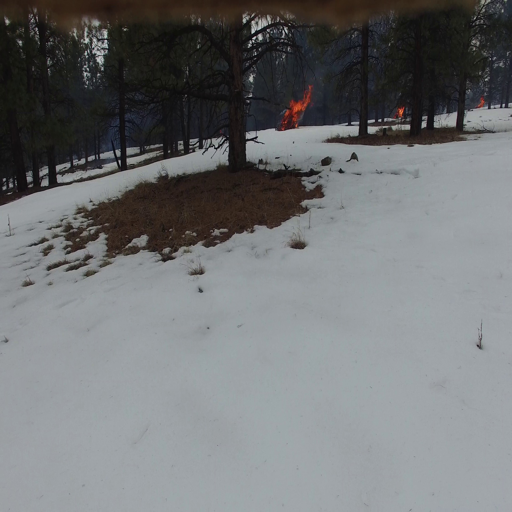

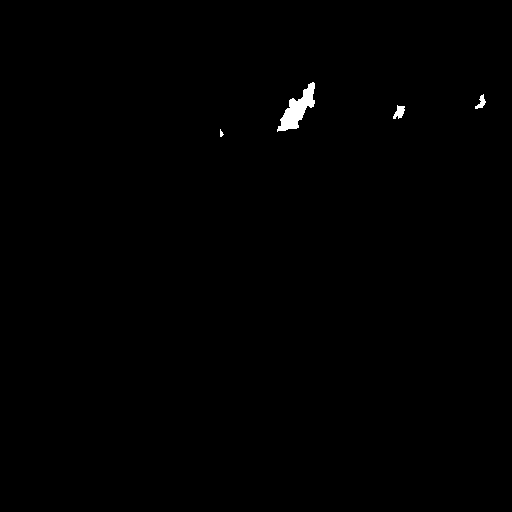

In [ ]:
img_path = '/content/drive/MyDrive/Major_Project_Resources/fire_segmentation/Images/Img/image_5.jpg'
image = Image.open(img_path)
new_size = (512, 512)
resized_image = image.resize(new_size)
resized_image.show()

mask_path = '/content/drive/MyDrive/Major_Project_Resources/fire_segmentation/MaskData/Masks/image_5.jpg'
mask = Image.open(mask_path)
new_size = (512, 512)
resized_mask = mask.resize(new_size)
resized_mask.show()


(1, 512, 512, 3)


/usr/local/lib/python3.9/dist-packages/tensorflow/python/data/ops/structured_function.py:254: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


1/1 [==============================] - 1s 784ms/step
255


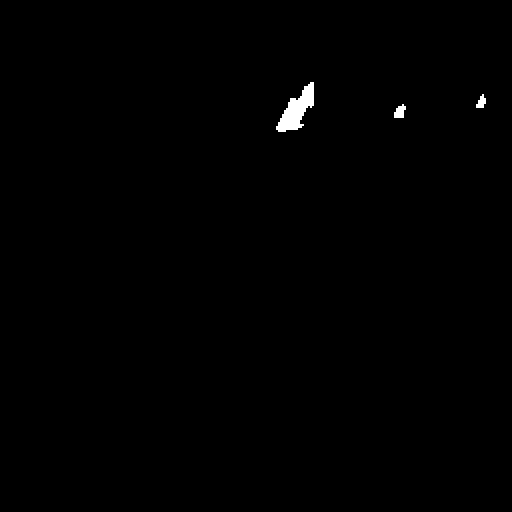

In [ ]:
# Prediction code :-

from keras.models import load_model
model_path = '/content/drive/MyDrive/Major_Project_Resources/fire_segmentation/Proposed_Models/AttSqueezeUNET_3.h5'
model = load_model(model_path,custom_objects={'iou_coef':iou_coef,'f1_metric':f1_metric,'focal_tversky_loss':focal_tversky_loss})
img_np = np.array(resized_image)
# img_np = img_np / 255.0
# img_reshape = trainImg.reshape((1,trainImg.shape[0],trainImg.shape[1],trainImg.shape[2]))
img_reshape = img_np.reshape((1,img_np.shape[0],img_np.shape[1],img_np.shape[2]))
print(img_reshape.shape)
op = model.predict(img_reshape)
op = np.where(op < 0.5,0,1)

op = op*255
print(op.max())

# print(op_reshape.shape)
cv2_imshow(op[0])
op=np.array(op)

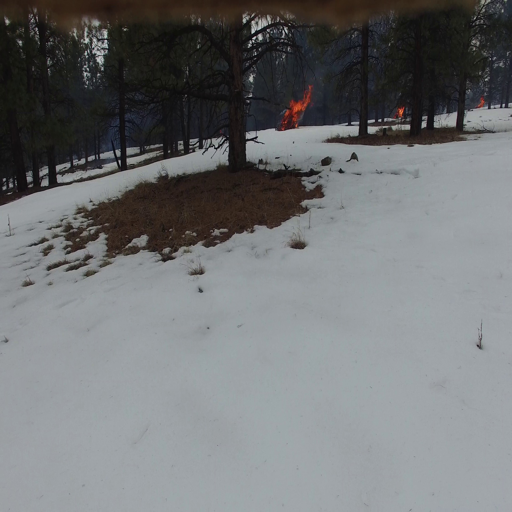

(1, 512, 512, 3)
1/1 [==============================] - 0s 54ms/step
255


/usr/local/lib/python3.9/dist-packages/tensorflow/python/data/ops/structured_function.py:254: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


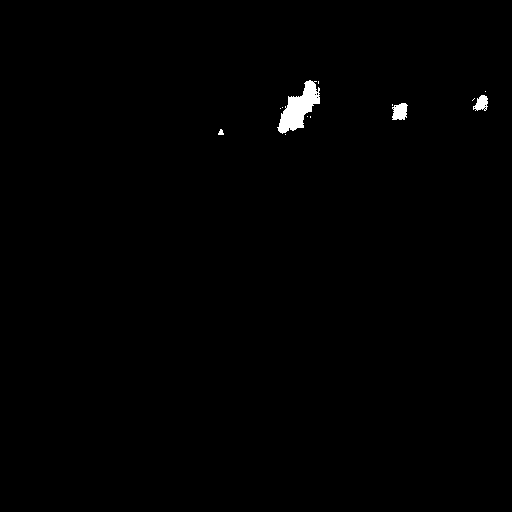

tf.Tensor(-1.0101686867059485, shape=(), dtype=float64)
[[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]]


In [ ]:
# Prediction code :-

from keras.models import load_model
model_path = '/content/drive/MyDrive/Major_Project_Resources/fire_segmentation/Proposed_Models/unet_kaggle.h5'
model = load_model(model_path,custom_objects={'iou_coef':iou_coef,'f1_metric':f1_metric})
resized_image.show()
img_np = np.array(resized_image)
# img_np = img_np / 255.0
# img_reshape = trainImg.reshape((1,trainImg.shape[0],trainImg.shape[1],trainImg.shape[2]))
img_reshape = img_np.reshape((1,img_np.shape[0],img_np.shape[1],img_np.shape[2]))
print(img_reshape.shape)
op = model.predict(img_reshape)
op = np.where(op < 0.5,0,1)
op = op*255
resized_mask=np.array(resized_mask)
print(op.max())
# print(op_reshape.shape)
cv2_imshow(op[0])
op=np.array(op)
print(iou_coef(op.reshape(1,512,512,1),(resized_mask*255).reshape(1,512,512,1)))
print(resized_mask)

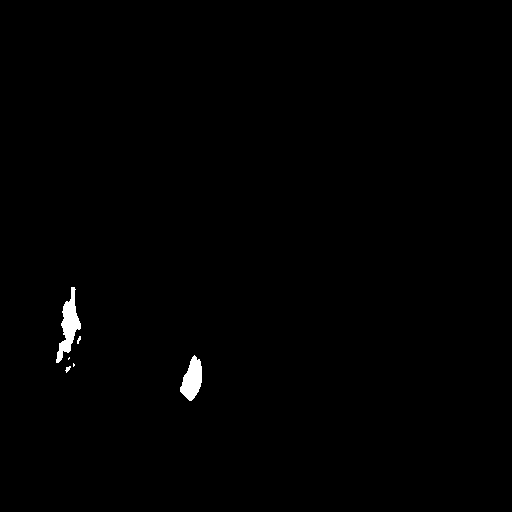

In [ ]:
resized_mask.show()

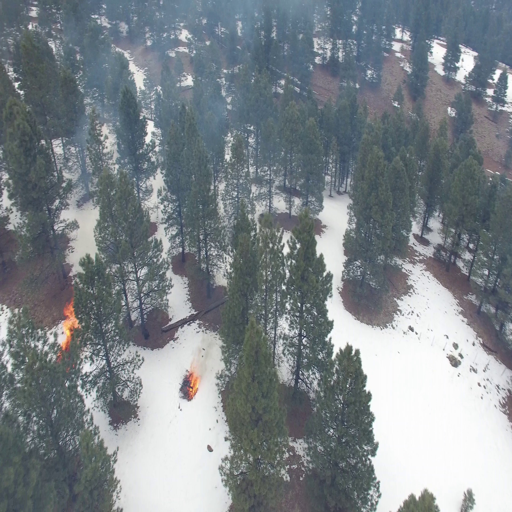

In [ ]:
resized_image.show()

In [ ]:
import numpy as np
from tensorflow.keras.backend import int_shape
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D,Conv2DTranspose, Conv3D, MaxPooling2D, MaxPooling3D, UpSampling2D, Add, BatchNormalization, Input, Activation, Lambda, Concatenate
from tensorflow.keras import regularizers


def residual_separable(inp, n_filters, dropout=0.3, dilation=1, l2=None, name="down"):
    x = tf.keras.layers.SeparableConv2D(n_filters, (3, 3), strides=1, padding='same', activation=None,
                        dilation_rate=dilation, use_bias=False, depthwise_initializer='glorot_uniform', pointwise_initializer='glorot_uniform',
                        pointwise_regularizer=regularizers.l2(0.00004))(inp)
    x = BatchNormalization()(x)
    x = Dropout(rate=dropout)(x)
    if inp.shape[3] == x.shape[3]:
        x = Add()([x, inp])
    x = Activation('relu')(x)
    return x

def residual_separable_multi(inp, n_filters, dropout=0.3, dilation=1, l2=None, name="down"):
    x = tf.keras.layers.DepthwiseConv2D(3, strides=(1, 1), depth_multiplier=1, padding='same', use_bias=False)(inp)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x2 = tf.keras.layers.DepthwiseConv2D(3, strides=(1, 1), depth_multiplier=1, dilation_rate= (dilation, dilation), padding='same', use_bias=False)(inp)
    x2 = BatchNormalization()(x2)
    x2 = Activation('relu')(x2)

    x +=x2

    x = Conv2D(n_filters, 1, strides=1, padding='same', activation=None,
                         dilation_rate=1, use_bias=False, kernel_regularizer=regularizers.l2(0.00004))(x)
    x = BatchNormalization()(x)

    x = Dropout(rate=dropout)(x)

    if inp.shape[3] == x.shape[3]:
        x = Add()([x, inp])

    x = Activation('relu')(x)
    return x


def encoder_module(inp, n_filters, dropout=0.3, dilation=[1,1], l2=None, name="down"):
    x = residual_separable(inp, n_filters, dropout=dropout, dilation=dilation[0], l2=l2, name=name)
    x = residual_separable(x, n_filters, dropout=dropout, dilation=dilation[1], l2=l2, name=name)
    return x

def encoder_module_multi(inp, n_filters, dropout=0.3, dilation=[1,1], l2=None, name="down"):
    x = residual_separable_multi(inp, n_filters, dropout=dropout, dilation=dilation[0], l2=l2, name=name)
    x = residual_separable_multi(x, n_filters, dropout=dropout, dilation=dilation[1], l2=l2, name=name)
    return x

def upsample(x, n_filters, last=False, l2=None, name="down"):
    x = Conv2DTranspose(n_filters, 3, strides=2, padding='same',use_bias=True,
                                   activation=None,
                                   kernel_regularizer=regularizers.l2(0.00004))(x)
    if not last:
        x = BatchNormalization()(x)
        x = Activation('relu')(x)

    return x

def downsample(inp, n_filters_in, n_filters_out, bn=False, use_relu=False, l2=None, name="down"):

    if n_filters_in < n_filters_out:
        filters_conv = n_filters_out - n_filters_in
    else:
        filters_conv = n_filters_out

    x = Conv2D(filters_conv, 3, strides=2, padding='same', activation=None,
                         dilation_rate=1, use_bias=False, kernel_regularizer=regularizers.l2(0.00004))(inp)

    if n_filters_in < n_filters_out:
        y =  MaxPooling2D(pool_size=(2, 2), strides=(2,2))(inp)
        x =  concatenate([x,y], axis = -1)

    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    return x

def dpp(x,f):
  x1 = tf.keras.layers.SeparableConv2D(f, (3, 3), padding='same', activation='relu',
                                       use_bias=False, depthwise_initializer='glorot_uniform', pointwise_initializer='glorot_uniform')(x)
  x2 = tf.keras.layers.SeparableConv2D(f, (3, 3), strides = 2, padding='same', activation='relu',
                                       use_bias=False, depthwise_initializer='glorot_uniform', pointwise_initializer='glorot_uniform')(x)
  x3 = tf.keras.layers.SeparableConv2D(f, (3, 3), strides = 4, padding='same', activation='relu',
                                       use_bias=False, depthwise_initializer='glorot_uniform', pointwise_initializer='glorot_uniform')(x)
  x1 = tf.keras.layers.SeparableConv2D(f, (3, 3), padding='same', activation='relu',
                                       use_bias=False, depthwise_initializer='glorot_uniform', pointwise_initializer='glorot_uniform')(x1)
  x2 = tf.keras.layers.SeparableConv2D(f, (3, 3), padding='same', activation='relu',
                                       use_bias=False, depthwise_initializer='glorot_uniform', pointwise_initializer='glorot_uniform')(x2)
  x3 = tf.keras.layers.SeparableConv2D(f, (3, 3), padding='same', activation='relu',
                                       use_bias=False, depthwise_initializer='glorot_uniform', pointwise_initializer='glorot_uniform')(x3)
  x1 = Conv2D(f,(1,1))(x1)
  x2 = Conv2DTranspose(f, 3, strides=2, padding='same',use_bias=True, activation='relu')(x2)
  x3 = Conv2DTranspose(f, 3, strides=4, padding='same',use_bias=True, activation='relu')(x3)
  x = concatenate([x3,x2,x1], axis=3)
  x1 = tf.keras.layers.SeparableConv2D(f, (3, 3), padding='same',dilation_rate = (1,1), activation='relu',
                                       use_bias=False, depthwise_initializer='glorot_uniform', pointwise_initializer='glorot_uniform')(x)
  x2 = tf.keras.layers.SeparableConv2D(f, (3, 3), padding='same',dilation_rate = (2,2), activation='relu',
                                       use_bias=False, depthwise_initializer='glorot_uniform', pointwise_initializer='glorot_uniform')(x)
  x3 = tf.keras.layers.SeparableConv2D(f, (3, 3), padding='same',dilation_rate = (4,4), activation='relu',
                                       use_bias=False, depthwise_initializer='glorot_uniform', pointwise_initializer='glorot_uniform')(x)
  x4 = tf.keras.layers.SeparableConv2D(f, (3, 3), padding='same',dilation_rate = (8,8), activation='relu',
                                       use_bias=False, depthwise_initializer='glorot_uniform', pointwise_initializer='glorot_uniform')(x)
  x = concatenate([x1,x2,x3,x4], axis=3)
  x = Conv2D(f,(1,1))(x)
  return x

import numpy as np
from tensorflow.keras.backend import int_shape
from tensorflow.keras.models import Model
from tensorflow.keras.layers import *
from tensorflow.keras import regularizers
import tensorflow as tf

def feature_extractor(x,f,dropout=0.25, dilation=[1,1,1,1], l2=None, name="down"):
  x1_1 = residual_separable_multi(x, f, dropout=dropout, dilation=1, l2=l2, name=name)
  x1_2 = residual_separable_multi(x, f//4, dropout=dropout, dilation=dilation[0], l2=l2, name=name)
  x2 = concatenate([x,x1_2])
  x2_1 = residual_separable_multi(x2, f, dropout=dropout, dilation=1, l2=l2, name=name)
  x2_2 = residual_separable_multi(x2_1, f//4, dropout=dropout, dilation=dilation[1], l2=l2, name=name)
  x3 = concatenate([x,x1_2,x2_2])
  x3_1 = residual_separable_multi(x3, f, dropout=dropout, dilation=1, l2=l2, name=name)
  x3_2 = residual_separable_multi(x3_1, f//4, dropout=dropout, dilation=dilation[2], l2=l2, name=name)
  x4 = concatenate([x,x1_2,x2_2,x3_2])
  x4_1 = residual_separable_multi(x4, f, dropout=dropout, dilation=1, l2=l2, name=name)
  x4_2 = residual_separable_multi(x4_1, f//4, dropout=dropout, dilation=dilation[3], l2=l2, name=name)
  xout = concatenate([x,x1_2,x2_2,x3_2,x4_2])
  return xout

from tensorflow.keras.layers import BatchNormalization, Activation, AveragePooling2D, DepthwiseConv2D, Conv2DTranspose
import tensorflow.keras.backend as K
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.layers import concatenate
from tensorflow.keras.layers import Activation,Reshape, Add, Multiply, DepthwiseConv2D, BatchNormalization, Concatenate, Conv2D, Dense,Dropout, GlobalAveragePooling2D, GlobalMaxPooling2D, Input, Lambda,LeakyReLU, MaxPooling2D, Multiply, Permute, Reshape, UpSampling2D
import collections
import tensorflow as tf


def dppnet(input_size,  n_classes, l2=None, upsampling=2):
    inputs = Input(input_size)
    d1 = downsample(inputs, 3, 8, l2=l2, name="d1")
    d2 = downsample(d1, n_filters_in=8, n_filters_out=32, l2=l2, name="d2")
    m1 = encoder_module(d2, n_filters=32, dilation=[1, 1], l2=l2, name="fres3", dropout=0.0)
    m2 = encoder_module(m1, n_filters=32, dilation=[1, 1], l2=l2, name="fres4", dropout=0.0)
    m3 = encoder_module(m2, n_filters=32, dilation=[1, 1], l2=l2, name="fres5", dropout=0.0)
    m4 = encoder_module(m3, n_filters=32, dilation=[1, 1], l2=l2, name="fres6", dropout=0.0)
    m5 = encoder_module(m4, n_filters=32, dilation=[1, 1], l2=l2, name="fres7", dropout=0.0)

    d3 = downsample(m5,  n_filters_in=32, n_filters_out=64, l2=l2, name="d8")
    m6 = feature_extractor(d3,64,dropout=0.25, dilation=[2,4,8,16], l2=l2, name="fres9")
    m7 = feature_extractor(m6,64,dropout=0.25, dilation=[1,2,8,16], l2=l2, name="fres10")
    up1 = upsample(m7, n_filters=32, l2=l2, name="up11")
    x = up1+d2
    up2 = upsample(x, n_filters=8, l2=l2, name="up16", last = True)
    x = concatenate([up2, d1], axis=3)
    x = dpp(x,16)
    x = Conv2D(1, (1, 1), activation='sigmoid')(x)
    if upsampling > 1:
      x = tf.keras.layers.experimental.preprocessing.Resizing(x.shape[1] * upsampling, x.shape[2] * upsampling)(x)


    model = Model(inputs, x)

    opt = Adam(learning_rate=0.001)
    model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    return model

model = dppnet((512,512,3), 1)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 5)  135         ['input_1[0][0]']                
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 256, 256, 3)  0           ['input_1[0][0]']                
                                                                                                  
 concatenate (Concatenate)      (None, 256, 256, 8)  0           ['conv2d[0][0]',             

In [ ]:
mcp_save = tf.keras.callbacks.ModelCheckpoint('/content/drive/MyDrive/Major_Project_Resources/fire_segmentation/Proposed_Models/dppnet.h5',monitor = 'val_iou_score', verbose=1, save_best_only=True, save_weights_only=False, mode='max')
model.compile(loss='binary_crossentropy',
             optimizer='adam',
             metrics=['accuracy',iou_coef,
              tf.keras.metrics.AUC(name='auc'),
              tf.keras.metrics.Precision(name='precision'),
              tf.keras.metrics.Recall(name='recall'),
              f1_metric])

In [ ]:
model_history = model.fit(train_img,train_mask,validation_data=(val_img,val_mask),epochs=50,steps_per_epoch=1600 // 32,validation_steps=5,callbacks = [mcp_save])

/usr/local/lib/python3.9/dist-packages/tensorflow/python/data/ops/structured_function.py:254: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Epoch 1/50
50/50 [==============================] - ETA: 0s - loss: 0.3204 - accuracy: 0.9825 - iou_coef: 0.0084 - auc: 0.5428 - precision: 0.0092 - recall: 0.0089 - f1_metric: 3.6827e-04

50/50 [==============================] - 75s 1s/step - loss: 0.3204 - accuracy: 0.9825 - iou_coef: 0.0084 - auc: 0.5428 - precision: 0.0092 - recall: 0.0089 - f1_metric: 3.6827e-04 - val_loss: 0.1237 - val_accuracy: 0.9908 - val_iou_coef: 9.5411e-04 - val_auc: 0.4955 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_metric: 0.0000e+00
Epoch 2/50
50/50 [==============================] - ETA: 0s - loss: 0.0535 - accuracy: 0.9910 - iou_coef: 0.0456 - auc: 0.9407 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_metric: 0.0000e+00

50/50 [==============================] - 69s 1s/step - loss: 0.0535 - accuracy: 0.9910 - iou_coef: 0.0456 - auc: 0.9407 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_metric: 0.0000e+00 - val_loss: 0.0702 - val_accuracy: 0.9908 - val_iou_coef: 0.0050 - val_auc: 0.6110 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_metric: 0.0000e+00
Epoch 3/50
50/50 [==============================] - ETA: 0s - loss: 0.0374 - accuracy: 0.9910 - iou_coef: 0.1005 - auc: 0.9816 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_metric: 0.0000e+00

50/50 [==============================] - 66s 1s/step - loss: 0.0374 - accuracy: 0.9910 - iou_coef: 0.1005 - auc: 0.9816 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_metric: 0.0000e+00 - val_loss: 0.0598 - val_accuracy: 0.9908 - val_iou_coef: 0.0088 - val_auc: 0.7958 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_metric: 0.0000e+00
Epoch 4/50
50/50 [==============================] - ETA: 0s - loss: 0.0293 - accuracy: 0.9910 - iou_coef: 0.1563 - auc: 0.9870 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_metric: 0.0000e+00

50/50 [==============================] - 66s 1s/step - loss: 0.0293 - accuracy: 0.9910 - iou_coef: 0.1563 - auc: 0.9870 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_metric: 0.0000e+00 - val_loss: 0.0526 - val_accuracy: 0.9908 - val_iou_coef: 0.0187 - val_auc: 0.8586 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_metric: 0.0000e+00
Epoch 5/50
50/50 [==============================] - ETA: 0s - loss: 0.0244 - accuracy: 0.9910 - iou_coef: 0.2092 - auc: 0.9896 - precision: 0.9355 - recall: 3.0733e-05 - f1_metric: 5.5597e-05

50/50 [==============================] - 66s 1s/step - loss: 0.0244 - accuracy: 0.9910 - iou_coef: 0.2092 - auc: 0.9896 - precision: 0.9355 - recall: 3.0733e-05 - f1_metric: 5.5597e-05 - val_loss: 0.0511 - val_accuracy: 0.9908 - val_iou_coef: 0.0259 - val_auc: 0.8800 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_metric: 0.0000e+00
Epoch 6/50
50/50 [==============================] - ETA: 0s - loss: 0.0206 - accuracy: 0.9938 - iou_coef: 0.3188 - auc: 0.9892 - precision: 0.7732 - recall: 0.4357 - f1_metric: 0.5141

50/50 [==============================] - 69s 1s/step - loss: 0.0206 - accuracy: 0.9938 - iou_coef: 0.3188 - auc: 0.9892 - precision: 0.7732 - recall: 0.4357 - f1_metric: 0.5141 - val_loss: 0.0560 - val_accuracy: 0.9908 - val_iou_coef: 0.0098 - val_auc: 0.7455 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_metric: 0.0000e+00
Epoch 7/50
50/50 [==============================] - ETA: 0s - loss: 0.0178 - accuracy: 0.9953 - iou_coef: 0.4117 - auc: 0.9927 - precision: 0.7691 - recall: 0.6841 - f1_metric: 0.7229

50/50 [==============================] - 66s 1s/step - loss: 0.0178 - accuracy: 0.9953 - iou_coef: 0.4117 - auc: 0.9927 - precision: 0.7691 - recall: 0.6841 - f1_metric: 0.7229 - val_loss: 0.0503 - val_accuracy: 0.9909 - val_iou_coef: 0.0286 - val_auc: 0.8017 - val_precision: 1.0000 - val_recall: 0.0133 - val_f1_metric: 0.0186
Epoch 8/50
50/50 [==============================] - ETA: 0s - loss: 0.0162 - accuracy: 0.9956 - iou_coef: 0.4393 - auc: 0.9949 - precision: 0.7795 - recall: 0.7079 - f1_metric: 0.7411

50/50 [==============================] - 66s 1s/step - loss: 0.0162 - accuracy: 0.9956 - iou_coef: 0.4393 - auc: 0.9949 - precision: 0.7795 - recall: 0.7079 - f1_metric: 0.7411 - val_loss: 0.0565 - val_accuracy: 0.9910 - val_iou_coef: 0.0316 - val_auc: 0.7019 - val_precision: 1.0000 - val_recall: 0.0276 - val_f1_metric: 0.0370
Epoch 9/50
50/50 [==============================] - ETA: 0s - loss: 0.0150 - accuracy: 0.9957 - iou_coef: 0.4633 - auc: 0.9959 - precision: 0.7899 - recall: 0.7165 - f1_metric: 0.7503

50/50 [==============================] - 66s 1s/step - loss: 0.0150 - accuracy: 0.9957 - iou_coef: 0.4633 - auc: 0.9959 - precision: 0.7899 - recall: 0.7165 - f1_metric: 0.7503 - val_loss: 0.0452 - val_accuracy: 0.9917 - val_iou_coef: 0.0926 - val_auc: 0.7951 - val_precision: 0.9936 - val_recall: 0.1000 - val_f1_metric: 0.1378
Epoch 10/50
50/50 [==============================] - ETA: 0s - loss: 0.0144 - accuracy: 0.9958 - iou_coef: 0.4699 - auc: 0.9961 - precision: 0.7918 - recall: 0.7210 - f1_metric: 0.7523

50/50 [==============================] - 66s 1s/step - loss: 0.0144 - accuracy: 0.9958 - iou_coef: 0.4699 - auc: 0.9961 - precision: 0.7918 - recall: 0.7210 - f1_metric: 0.7523 - val_loss: 0.0462 - val_accuracy: 0.9923 - val_iou_coef: 0.1341 - val_auc: 0.7800 - val_precision: 0.9718 - val_recall: 0.1642 - val_f1_metric: 0.2285
Epoch 11/50
50/50 [==============================] - ETA: 0s - loss: 0.0137 - accuracy: 0.9959 - iou_coef: 0.4827 - auc: 0.9967 - precision: 0.7932 - recall: 0.7290 - f1_metric: 0.7582

50/50 [==============================] - 68s 1s/step - loss: 0.0137 - accuracy: 0.9959 - iou_coef: 0.4827 - auc: 0.9967 - precision: 0.7932 - recall: 0.7290 - f1_metric: 0.7582 - val_loss: 0.0349 - val_accuracy: 0.9938 - val_iou_coef: 0.2742 - val_auc: 0.8488 - val_precision: 0.9248 - val_recall: 0.3507 - val_f1_metric: 0.4714
Epoch 12/50
50/50 [==============================] - ETA: 0s - loss: 0.0131 - accuracy: 0.9959 - iou_coef: 0.4918 - auc: 0.9970 - precision: 0.7975 - recall: 0.7324 - f1_metric: 0.7617

50/50 [==============================] - 65s 1s/step - loss: 0.0131 - accuracy: 0.9959 - iou_coef: 0.4918 - auc: 0.9970 - precision: 0.7975 - recall: 0.7324 - f1_metric: 0.7617 - val_loss: 0.0252 - val_accuracy: 0.9947 - val_iou_coef: 0.3896 - val_auc: 0.9169 - val_precision: 0.8713 - val_recall: 0.5044 - val_f1_metric: 0.6130
Epoch 13/50
50/50 [==============================] - ETA: 0s - loss: 0.0127 - accuracy: 0.9959 - iou_coef: 0.4971 - auc: 0.9970 - precision: 0.7991 - recall: 0.7341 - f1_metric: 0.7642

50/50 [==============================] - 68s 1s/step - loss: 0.0127 - accuracy: 0.9959 - iou_coef: 0.4971 - auc: 0.9970 - precision: 0.7991 - recall: 0.7341 - f1_metric: 0.7642 - val_loss: 0.0214 - val_accuracy: 0.9949 - val_iou_coef: 0.4130 - val_auc: 0.9432 - val_precision: 0.8733 - val_recall: 0.5254 - val_f1_metric: 0.6379
Epoch 14/50
50/50 [==============================] - ETA: 0s - loss: 0.0123 - accuracy: 0.9960 - iou_coef: 0.4996 - auc: 0.9972 - precision: 0.8009 - recall: 0.7330 - f1_metric: 0.7639

50/50 [==============================] - 65s 1s/step - loss: 0.0123 - accuracy: 0.9960 - iou_coef: 0.4996 - auc: 0.9972 - precision: 0.8009 - recall: 0.7330 - f1_metric: 0.7639 - val_loss: 0.0192 - val_accuracy: 0.9952 - val_iou_coef: 0.4371 - val_auc: 0.9549 - val_precision: 0.8501 - val_recall: 0.5827 - val_f1_metric: 0.6727
Epoch 15/50
50/50 [==============================] - ETA: 0s - loss: 0.0119 - accuracy: 0.9960 - iou_coef: 0.5085 - auc: 0.9975 - precision: 0.8035 - recall: 0.7390 - f1_metric: 0.7689

50/50 [==============================] - 68s 1s/step - loss: 0.0119 - accuracy: 0.9960 - iou_coef: 0.5085 - auc: 0.9975 - precision: 0.8035 - recall: 0.7390 - f1_metric: 0.7689 - val_loss: 0.0159 - val_accuracy: 0.9956 - val_iou_coef: 0.4914 - val_auc: 0.9730 - val_precision: 0.8291 - val_recall: 0.6569 - val_f1_metric: 0.7251
Epoch 16/50
50/50 [==============================] - ETA: 0s - loss: 0.0115 - accuracy: 0.9960 - iou_coef: 0.5109 - auc: 0.9976 - precision: 0.8061 - recall: 0.7378 - f1_metric: 0.7689

50/50 [==============================] - 68s 1s/step - loss: 0.0115 - accuracy: 0.9960 - iou_coef: 0.5109 - auc: 0.9976 - precision: 0.8061 - recall: 0.7378 - f1_metric: 0.7689 - val_loss: 0.0137 - val_accuracy: 0.9957 - val_iou_coef: 0.5080 - val_auc: 0.9854 - val_precision: 0.8078 - val_recall: 0.7060 - val_f1_metric: 0.7453
Epoch 17/50
50/50 [==============================] - ETA: 0s - loss: 0.0113 - accuracy: 0.9961 - iou_coef: 0.5135 - auc: 0.9976 - precision: 0.8058 - recall: 0.7397 - f1_metric: 0.7699

50/50 [==============================] - 66s 1s/step - loss: 0.0113 - accuracy: 0.9961 - iou_coef: 0.5135 - auc: 0.9976 - precision: 0.8058 - recall: 0.7397 - f1_metric: 0.7699 - val_loss: 0.0149 - val_accuracy: 0.9956 - val_iou_coef: 0.4978 - val_auc: 0.9776 - val_precision: 0.8243 - val_recall: 0.6692 - val_f1_metric: 0.7280
Epoch 18/50
50/50 [==============================] - ETA: 0s - loss: 0.0112 - accuracy: 0.9960 - iou_coef: 0.5109 - auc: 0.9976 - precision: 0.8050 - recall: 0.7381 - f1_metric: 0.7683

50/50 [==============================] - 65s 1s/step - loss: 0.0112 - accuracy: 0.9960 - iou_coef: 0.5109 - auc: 0.9976 - precision: 0.8050 - recall: 0.7381 - f1_metric: 0.7683 - val_loss: 0.0201 - val_accuracy: 0.9954 - val_iou_coef: 0.4509 - val_auc: 0.9410 - val_precision: 0.8486 - val_recall: 0.6031 - val_f1_metric: 0.6848
Epoch 19/50
50/50 [==============================] - ETA: 0s - loss: 0.0109 - accuracy: 0.9961 - iou_coef: 0.5176 - auc: 0.9978 - precision: 0.8075 - recall: 0.7399 - f1_metric: 0.7710

50/50 [==============================] - 68s 1s/step - loss: 0.0109 - accuracy: 0.9961 - iou_coef: 0.5176 - auc: 0.9978 - precision: 0.8075 - recall: 0.7399 - f1_metric: 0.7710 - val_loss: 0.0143 - val_accuracy: 0.9958 - val_iou_coef: 0.5159 - val_auc: 0.9769 - val_precision: 0.8300 - val_recall: 0.6836 - val_f1_metric: 0.7441
Epoch 20/50
50/50 [==============================] - ETA: 0s - loss: 0.0108 - accuracy: 0.9961 - iou_coef: 0.5175 - auc: 0.9976 - precision: 0.8100 - recall: 0.7378 - f1_metric: 0.7714

50/50 [==============================] - 65s 1s/step - loss: 0.0108 - accuracy: 0.9961 - iou_coef: 0.5175 - auc: 0.9976 - precision: 0.8100 - recall: 0.7378 - f1_metric: 0.7714 - val_loss: 0.0151 - val_accuracy: 0.9957 - val_iou_coef: 0.5114 - val_auc: 0.9720 - val_precision: 0.8081 - val_recall: 0.7036 - val_f1_metric: 0.7433
Epoch 21/50
50/50 [==============================] - ETA: 0s - loss: 0.0107 - accuracy: 0.9961 - iou_coef: 0.5175 - auc: 0.9977 - precision: 0.8109 - recall: 0.7358 - f1_metric: 0.7689

50/50 [==============================] - 68s 1s/step - loss: 0.0107 - accuracy: 0.9961 - iou_coef: 0.5175 - auc: 0.9977 - precision: 0.8109 - recall: 0.7358 - f1_metric: 0.7689 - val_loss: 0.0122 - val_accuracy: 0.9959 - val_iou_coef: 0.5238 - val_auc: 0.9889 - val_precision: 0.8285 - val_recall: 0.7000 - val_f1_metric: 0.7526
Epoch 22/50
50/50 [==============================] - ETA: 0s - loss: 0.0104 - accuracy: 0.9961 - iou_coef: 0.5228 - auc: 0.9978 - precision: 0.8106 - recall: 0.7411 - f1_metric: 0.7729

50/50 [==============================] - 66s 1s/step - loss: 0.0104 - accuracy: 0.9961 - iou_coef: 0.5228 - auc: 0.9978 - precision: 0.8106 - recall: 0.7411 - f1_metric: 0.7729 - val_loss: 0.0126 - val_accuracy: 0.9959 - val_iou_coef: 0.5271 - val_auc: 0.9856 - val_precision: 0.8228 - val_recall: 0.7070 - val_f1_metric: 0.7531
Epoch 23/50
50/50 [==============================] - ETA: 0s - loss: 0.0104 - accuracy: 0.9961 - iou_coef: 0.5193 - auc: 0.9977 - precision: 0.8119 - recall: 0.7352 - f1_metric: 0.7694

50/50 [==============================] - 65s 1s/step - loss: 0.0104 - accuracy: 0.9961 - iou_coef: 0.5193 - auc: 0.9977 - precision: 0.8119 - recall: 0.7352 - f1_metric: 0.7694 - val_loss: 0.0114 - val_accuracy: 0.9960 - val_iou_coef: 0.5229 - val_auc: 0.9937 - val_precision: 0.8362 - val_recall: 0.6982 - val_f1_metric: 0.7553
Epoch 24/50
50/50 [==============================] - ETA: 0s - loss: 0.0103 - accuracy: 0.9961 - iou_coef: 0.5213 - auc: 0.9977 - precision: 0.8124 - recall: 0.7382 - f1_metric: 0.7721

50/50 [==============================] - 65s 1s/step - loss: 0.0103 - accuracy: 0.9961 - iou_coef: 0.5213 - auc: 0.9977 - precision: 0.8124 - recall: 0.7382 - f1_metric: 0.7721 - val_loss: 0.0115 - val_accuracy: 0.9959 - val_iou_coef: 0.5199 - val_auc: 0.9921 - val_precision: 0.8514 - val_recall: 0.6741 - val_f1_metric: 0.7467
Epoch 25/50
50/50 [==============================] - ETA: 0s - loss: 0.0100 - accuracy: 0.9961 - iou_coef: 0.5290 - auc: 0.9980 - precision: 0.8127 - recall: 0.7419 - f1_metric: 0.7750

50/50 [==============================] - 65s 1s/step - loss: 0.0100 - accuracy: 0.9961 - iou_coef: 0.5290 - auc: 0.9980 - precision: 0.8127 - recall: 0.7419 - f1_metric: 0.7750 - val_loss: 0.0126 - val_accuracy: 0.9959 - val_iou_coef: 0.5218 - val_auc: 0.9835 - val_precision: 0.8279 - val_recall: 0.6957 - val_f1_metric: 0.7483
Epoch 26/50
50/50 [==============================] - ETA: 0s - loss: 0.0099 - accuracy: 0.9961 - iou_coef: 0.5275 - auc: 0.9979 - precision: 0.8148 - recall: 0.7387 - f1_metric: 0.7739

50/50 [==============================] - 65s 1s/step - loss: 0.0099 - accuracy: 0.9961 - iou_coef: 0.5275 - auc: 0.9979 - precision: 0.8148 - recall: 0.7387 - f1_metric: 0.7739 - val_loss: 0.0130 - val_accuracy: 0.9958 - val_iou_coef: 0.5283 - val_auc: 0.9803 - val_precision: 0.8371 - val_recall: 0.6784 - val_f1_metric: 0.7441
Epoch 27/50
50/50 [==============================] - ETA: 0s - loss: 0.0098 - accuracy: 0.9962 - iou_coef: 0.5292 - auc: 0.9980 - precision: 0.8158 - recall: 0.7391 - f1_metric: 0.7746

50/50 [==============================] - 65s 1s/step - loss: 0.0098 - accuracy: 0.9962 - iou_coef: 0.5292 - auc: 0.9980 - precision: 0.8158 - recall: 0.7391 - f1_metric: 0.7746 - val_loss: 0.0116 - val_accuracy: 0.9960 - val_iou_coef: 0.5438 - val_auc: 0.9878 - val_precision: 0.7957 - val_recall: 0.7547 - val_f1_metric: 0.7680
Epoch 28/50
50/50 [==============================] - ETA: 0s - loss: 0.0098 - accuracy: 0.9961 - iou_coef: 0.5279 - auc: 0.9979 - precision: 0.8142 - recall: 0.7395 - f1_metric: 0.7732

50/50 [==============================] - 65s 1s/step - loss: 0.0098 - accuracy: 0.9961 - iou_coef: 0.5279 - auc: 0.9979 - precision: 0.8142 - recall: 0.7395 - f1_metric: 0.7732 - val_loss: 0.0114 - val_accuracy: 0.9960 - val_iou_coef: 0.5496 - val_auc: 0.9881 - val_precision: 0.8044 - val_recall: 0.7458 - val_f1_metric: 0.7696
Epoch 29/50
50/50 [==============================] - ETA: 0s - loss: 0.0097 - accuracy: 0.9961 - iou_coef: 0.5294 - auc: 0.9979 - precision: 0.8148 - recall: 0.7396 - f1_metric: 0.7741

50/50 [==============================] - 67s 1s/step - loss: 0.0097 - accuracy: 0.9961 - iou_coef: 0.5294 - auc: 0.9979 - precision: 0.8148 - recall: 0.7396 - f1_metric: 0.7741 - val_loss: 0.0119 - val_accuracy: 0.9959 - val_iou_coef: 0.5118 - val_auc: 0.9864 - val_precision: 0.8507 - val_recall: 0.6714 - val_f1_metric: 0.7432
Epoch 30/50
50/50 [==============================] - ETA: 0s - loss: 0.0097 - accuracy: 0.9961 - iou_coef: 0.5281 - auc: 0.9979 - precision: 0.8168 - recall: 0.7365 - f1_metric: 0.7734

50/50 [==============================] - 66s 1s/step - loss: 0.0097 - accuracy: 0.9961 - iou_coef: 0.5281 - auc: 0.9979 - precision: 0.8168 - recall: 0.7365 - f1_metric: 0.7734 - val_loss: 0.0106 - val_accuracy: 0.9960 - val_iou_coef: 0.5433 - val_auc: 0.9935 - val_precision: 0.7996 - val_recall: 0.7576 - val_f1_metric: 0.7735
Epoch 31/50
50/50 [==============================] - ETA: 0s - loss: 0.0096 - accuracy: 0.9962 - iou_coef: 0.5294 - auc: 0.9977 - precision: 0.8177 - recall: 0.7376 - f1_metric: 0.7741

50/50 [==============================] - 67s 1s/step - loss: 0.0096 - accuracy: 0.9962 - iou_coef: 0.5294 - auc: 0.9977 - precision: 0.8177 - recall: 0.7376 - f1_metric: 0.7741 - val_loss: 0.0105 - val_accuracy: 0.9960 - val_iou_coef: 0.5365 - val_auc: 0.9934 - val_precision: 0.8269 - val_recall: 0.7189 - val_f1_metric: 0.7656
Epoch 32/50
50/50 [==============================] - ETA: 0s - loss: 0.0095 - accuracy: 0.9962 - iou_coef: 0.5308 - auc: 0.9980 - precision: 0.8176 - recall: 0.7382 - f1_metric: 0.7746

50/50 [==============================] - 65s 1s/step - loss: 0.0095 - accuracy: 0.9962 - iou_coef: 0.5308 - auc: 0.9980 - precision: 0.8176 - recall: 0.7382 - f1_metric: 0.7746 - val_loss: 0.0106 - val_accuracy: 0.9960 - val_iou_coef: 0.5614 - val_auc: 0.9921 - val_precision: 0.7946 - val_recall: 0.7683 - val_f1_metric: 0.7764
Epoch 33/50
50/50 [==============================] - ETA: 0s - loss: 0.0094 - accuracy: 0.9962 - iou_coef: 0.5324 - auc: 0.9980 - precision: 0.8167 - recall: 0.7395 - f1_metric: 0.7752

50/50 [==============================] - 65s 1s/step - loss: 0.0094 - accuracy: 0.9962 - iou_coef: 0.5324 - auc: 0.9980 - precision: 0.8167 - recall: 0.7395 - f1_metric: 0.7752 - val_loss: 0.0104 - val_accuracy: 0.9961 - val_iou_coef: 0.5386 - val_auc: 0.9933 - val_precision: 0.8283 - val_recall: 0.7264 - val_f1_metric: 0.7682
Epoch 34/50
50/50 [==============================] - ETA: 0s - loss: 0.0096 - accuracy: 0.9961 - iou_coef: 0.5265 - auc: 0.9975 - precision: 0.8180 - recall: 0.7332 - f1_metric: 0.7712

50/50 [==============================] - 68s 1s/step - loss: 0.0096 - accuracy: 0.9961 - iou_coef: 0.5265 - auc: 0.9975 - precision: 0.8180 - recall: 0.7332 - f1_metric: 0.7712 - val_loss: 0.0105 - val_accuracy: 0.9961 - val_iou_coef: 0.5502 - val_auc: 0.9920 - val_precision: 0.8335 - val_recall: 0.7190 - val_f1_metric: 0.7673
Epoch 35/50
50/50 [==============================] - ETA: 0s - loss: 0.0094 - accuracy: 0.9962 - iou_coef: 0.5333 - auc: 0.9980 - precision: 0.8171 - recall: 0.7394 - f1_metric: 0.7745

50/50 [==============================] - 65s 1s/step - loss: 0.0094 - accuracy: 0.9962 - iou_coef: 0.5333 - auc: 0.9980 - precision: 0.8171 - recall: 0.7394 - f1_metric: 0.7745 - val_loss: 0.0100 - val_accuracy: 0.9961 - val_iou_coef: 0.5519 - val_auc: 0.9955 - val_precision: 0.8006 - val_recall: 0.7641 - val_f1_metric: 0.7774
Epoch 36/50
50/50 [==============================] - ETA: 0s - loss: 0.0094 - accuracy: 0.9962 - iou_coef: 0.5321 - auc: 0.9979 - precision: 0.8191 - recall: 0.7348 - f1_metric: 0.7730

50/50 [==============================] - 65s 1s/step - loss: 0.0094 - accuracy: 0.9962 - iou_coef: 0.5321 - auc: 0.9979 - precision: 0.8191 - recall: 0.7348 - f1_metric: 0.7730 - val_loss: 0.0099 - val_accuracy: 0.9961 - val_iou_coef: 0.5473 - val_auc: 0.9959 - val_precision: 0.8015 - val_recall: 0.7625 - val_f1_metric: 0.7779
Epoch 37/50
49/50 [============================>.] - ETA: 1s - loss: 0.0093 - accuracy: 0.9962 - iou_coef: 0.5348 - auc: 0.9980 - precision: 0.8200 - recall: 0.7379 - f1_metric: 0.7754